In [1]:
 !nvidia-smi

Fri Sep 23 14:48:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:03:00.0 Off |                  N/A |
| 24%   45C    P8    11W / 250W |    104MiB / 12188MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro P6000        Off  | 00000000:81:00.0 Off |                  Off |
| 52%   

In [2]:
import sys
sys.path.append('../')

In [3]:
from utils.cloudant_utils import cloudant_db as db
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch import nn
from collections import defaultdict
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from prepare_sequence import prepareSequenceForBERT
import random
from tqdm.auto import tqdm

SUCCESS connecting to Cloudant db github-public-ai-2022


/users/kent/jmaharja/anaconda3/envs/crawler/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch
torch.cuda.empty_cache()
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [5]:
BATCH_SIZE = 16
MAX_LEN = 512
EPOCHS = 16
RANDOM_SEED = 42
model_name = 'bert-base-uncased'

In [6]:
# repos = [r for r in db.get_query_result({"type": "release"}, ["_id", "releases"], limit=10000, raw_result=True)["docs"]]
# values = [r for release in repos for r in release["releases"]]
# df = pd.DataFrame(values)
# df['contributors'] = df['contributors'].apply(lambda x:
#                                               [i for i in x if i is not None] if isinstance(x, list)
#                                               else [])
# df = df[~df['readme'].isnull()]
# new_df = df.groupby("repo").agg({"readme": list,
#                                  "total_stars": list,
# #                                  "forks": sum,
# #                                  "downloads": sum,
# #                                  "contributors": sum
# #                                  "releases": count
#                                 })
# new_df = new_df[new_df['readme'].map(len) > 1]
# # new_df = new_df[:10]
# new_df['k'] = new_df['total_stars'].map(lambda x: random.randint(2, len(x)))
# new_df['readme1'] = new_df.apply(lambda x: x.readme[:x.k], axis=1)
# new_df['target_val'] = new_df.apply(lambda x: x.total_stars[x.k-1], axis=1)
# new_df['sequence']= new_df['readme1'].apply(prepareSequenceForBERT)
# new_df['target'] = new_df.apply(lambda x: 1 if x.target_val> 600 else 0, axis=1)

In [7]:
new_df = pd.read_csv('csv/inputForBERT_2022_09_21-09_14PM.csv') 

In [8]:
new_df['target'].value_counts()

0    2687
1     509
Name: target, dtype: int64

In [9]:
class ReadmeDataSet(Dataset):
   def __init__(self, _df, tokenizer, max_len):
      self._df = _df
      self.tokenizer = tokenizer
      self.max_len = max_len

   def __len__(self):
      return len(self._df)

   def __getitem__(self, item):
      _sequence = self._df.iloc[item]['sequence']
      target = self._df.iloc[item]['target']
      encoding = self.tokenizer.encode_plus(_sequence,
                                     None,
                                     max_length = self.max_len,
                                     truncation=True,
                                     add_special_tokens=True,
                                     padding='max_length',
                                     return_token_type_ids=True)

      return {
      'sequence': _sequence,
      'input_ids': torch.tensor(encoding.input_ids, dtype=torch.long),
      'attention_mask':  torch.tensor(encoding.attention_mask, dtype=torch.long),
      'token_type_ids': torch.tensor(encoding.token_type_ids, dtype=torch.long),
      'targets': torch.tensor(target, dtype=torch.long)
      }

In [10]:
def create_data_loader(_df, tokenizer, max_len, batch_size):
   ds = ReadmeDataSet(_df = _df, tokenizer=tokenizer, max_len=max_len)
   return DataLoader(ds, batch_size=batch_size, num_workers=0)

In [23]:
class BertForRepoClassification(nn.Module):
    def __init__(self, n_classes):
        super(BertForRepoClassification, self).__init__()
        self.model = BertModel.from_pretrained('bert-base-uncased')
        self.drop_out = nn.Dropout(0.3)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.classifier = nn.Linear(768, n_classes)
        
    def forward(self, input_ids, attention_mask,token_type_ids):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask,token_type_ids=token_type_ids)
#         last_hidden_state = last_hidden_state[:, 0]
#         print(outputs)
#         print(pooled_output.shape)
        pooled_output = self.drop_out(outputs.pooler_output)
        output = self.classifier(pooled_output)
        return output

Import BERT Tokenizer and BERT Model

In [24]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
#                                                       num_labels=2,
#                                                       output_attentions= False,
#                                                       output_hidden_states= False)
bert_model = BertForRepoClassification(2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

df_train, df_test = train_test_split(new_df, test_size=0.4, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((1917, 8), (639, 8), (640, 8))

In [14]:
train_data_loader = create_data_loader(df_train, bert_tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, bert_tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, bert_tokenizer, MAX_LEN, BATCH_SIZE)
new_df.shape, df_train.shape, df_val.shape, df_test.shape

((3196, 8), (1917, 8), (639, 8), (640, 8))

In [15]:
# TEST the tokenizer and data loader
# sequence = prepareSequenceForBERT(new_df.iloc[1]['readme'][:7])
# label = new_df.iloc[1]['total_stars'][6]
# tokens = bert_tokenizer.encode_plus(
#             sequence,
#             None,
#             max_length= 512,
#             truncation=True,
#             add_special_tokens=True,
# #             pad_to_max_length=True,
#             padding = True,
#             return_token_type_ids=True
#         )
# # print(f' Sentence: {sequence}')
# # print(f' Tokens: {tokens}')
# # print(f' Tokens.token_type_ids: {tokens.token_type_ids}')
# # print(f' Tokens.input_ids: {len(tokens.input_ids)}')
# output = {
#       'input_ids': torch.tensor(tokens.input_ids, dtype=torch.long),
#       'attention_mask':  torch.tensor(tokens.attention_mask, dtype=torch.long),
#       'token_type_ids': torch.tensor(tokens.token_type_ids, dtype=torch.long),
#       'targets': torch.tensor(label, dtype=torch.long)
#     }
# print(output['input_ids'].shape)
# model = BertModel.from_pretrained('bert-base-uncased')
# outputs = model(input_ids=output['input_ids'],attention_mask=output['attention_mask'])
# print(outputs)

In [16]:
# model = BertModel.from_pretrained('bert-base-uncased')
# model = model.to(device)
# for d in train_data_loader:
#     input_ids = d["input_ids"].to(device)
#     attention_mask = d["attention_mask"].to(device)
#     token_type_ids = d["token_type_ids"].to(device)
#     targets = d["targets"].to(device)
#     outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
#     print(outputs.last_hidden_state.shape)
#     print(input_ids.shape)
#     print(outputs.keys())
#     print(d['sequence'])
#     break

In [17]:
optimizer = AdamW(bert_model.parameters(), lr=2e-5, correct_bias=False, no_deprecation_warning=True)
bert_model = bert_model.to(device)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [18]:
def train_epoch( model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [19]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
print(40*"*", 'Training')
current_time = datetime.now().strftime("%Y_%m_%d-%I_%M%p")
print(current_time)
history = defaultdict(list)
loss_fn = nn.CrossEntropyLoss().to(device)
best_accuracy = 0
progress_bar = tqdm(range(total_steps))

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(bert_model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model( bert_model, val_data_loader, loss_fn, device, len(df_val) )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      curr_time = datetime.now().strftime("%Y_%m_%d-%I_%M%p")
      torch.save(bert_model.state_dict(), 'checkpoint/best_model_state' + current_time+'.bin')
      best_accuracy = val_acc
    progress_bar.update(1)

In [27]:
def get_predictions(model, data_loader):
  model = model.eval()

  sequences = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["sequence"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

      _, preds = torch.max(outputs, dim=1)
      probs = F.softmax(outputs, dim=1)

      sequences.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return outputs, sequences, predictions, prediction_probs, real_values

In [37]:
outputss, y_sequences, y_pred, y_pred_probs, y_test = get_predictions(bert_model, val_data_loader)

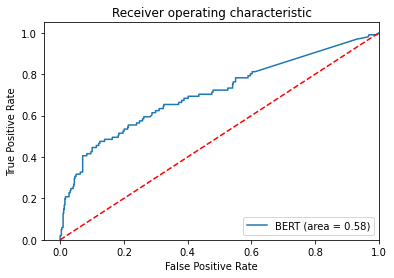

In [38]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test.numpy(), y_pred_probs[:, 1].numpy())
plt.figure()
plt.plot(fpr, tpr, label='BERT (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images/Log_ROC_'+ current_time +'.png')
plt.show()

In [ ]:
# optimal_indx = np.argmax(tpr-fpr)
# optimal_indx, tpr.shape
# thresholds[optimal_indx]

In [39]:
y_pred_probs_pd = [y.numpy() for y in y_pred_probs]
someListOfLists = list(zip(y_sequences, y_test.numpy(), y_pred.numpy(), y_pred_probs[:, 1:].numpy().squeeze(), y_pred_probs_pd ))
npa = np.asarray(someListOfLists)
dff = pd.DataFrame(someListOfLists, columns = ['readme', 'Real', 'Predicted', 'Pred-prob', 'All Pred-probs' ])
dff

/tmp/ipykernel_31846/2889840059.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  npa = np.asarray(someListOfLists)


,readme,Real,Predicted,Pred-prob,All Pred-probs
0,"[CLS]1st edition, published September 23rd 201...",1,0,0.448916,"[0.55108374, 0.44891623]"
1,[CLS] Please read this paper about evaluation ...,1,0,0.088245,"[0.91175526, 0.0882447]"
2,"[CLS] and preprocessing,Gaussian noise\n,patch...",0,0,0.085211,"[0.9147895, 0.08521051]"
3,[CLS]Depreciation Notice\nAll functions in wil...,0,0,0.077900,"[0.92209977, 0.07790021]"
4,[CLS][SEP],0,0,0.077601,"[0.9223993, 0.07760077]"
...,...,...,...,...,...
634,[CLS][SEP]\n6. What GPUs do you support?\nThe ...,0,0,0.078006,"[0.92199385, 0.078006186]"
635,[CLS]New Release version 0.7.0\nTensorboard su...,0,0,0.138693,"[0.86130697, 0.13869306]"
636,[CLS][SEP],0,0,0.077601,"[0.9223993, 0.07760077]"
637,[CLS][SEP],0,0,0.077601,"[0.9223993, 0.07760077]"


In [ ]:
dff.to_csv('csv/prediction_result'+ current_time+'.csv')

In [40]:
test_acc, _ = eval_model(bert_model, test_data_loader, loss_fn, device, len(df_test))
test_acc.item()

0.8234375

  0%|                                                                                                                                                                                                                                                  | 0/1920 [43:17<?, ?it/s]

In [34]:
bert_model.load_state_dict(torch.load('checkpoint/best_model_state2022_09_22-02_24PM.bin'))
bert_model = bert_model.to(device)